# DSFB Assignment 2 - Housing Prices

By [Omid Shahmirzadi](https://ch.linkedin.com/in/omidshahmirzadi) - Email  [omid.shahmirzadi@epfl.ch](mailto:omid.shahmirzadi@epfl.ch)

In this problem, you will try to predict the sale price of houses located in Ames, Iowa based on sevaral features. 

![](https://www.andrewgranger.co.uk/wp-content/uploads/2016/05/rsz_bigstock-terraced-roof-tops-46822489.jpg)

Image source: https://www.andrewgranger.co.uk/wp-content/uploads/2016/05/rsz_bigstock-terraced-roof-tops-46822489.jpg

Dataset source: https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt

The dataset consists of information of 1460 houses with 80 features, described in *data_description.txt* file. The target is given in a separate field called 'SalesPrice' in US dollar. As you will see, this dataset includes numerous features of different kinds which can introduce a nice playground for feature engineering techniques. Moreover you can practice bulding predictive models where number of observations to number of features ratio is not huge.  

You can create a group of up to three to discuss the problem, however every body is encouraged to implement the solution on his own machine. Remember to name your group mates in your submission. 

To assess the quality of your predictions, consider the root mean square error between the logarithm of the predicted value and the logarithm of the observed sales price.

## Part 1: Data Cleaning and EDA

**Q 1:** Investigate observations with null feature values. Do you see any structure in the missing values ? 

Hint: For every feature, calculate how many observations have missing values. Also calculate the percentage of observations where each feature is missing. You can also create a heatmap using *seaborn.heatmap()* function and feed it with *dataframe.isnull()* This approach returns an object of the same size with boolean values to indicate if values are missing. 

In [1]:
# Load data
import pandas as pd

data = pd.read_csv('house_data.csv')
print('This is a preview of the raw data')
data.head()

This is a preview of the raw data


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
data_nan = data.isna()
print('The white holes in the graph are missing values in the raw data')
sns.heatmap(data_nan)

The white holes in the graph are missing values in the raw data


In [3]:
# create a dataframe that descirbe the number of nan and its percentage for each feature
miss = pd.DataFrame(data_nan.sum())
# Rename column
miss.columns=['nb NaN']
# add the percentage of missing value for each feature
miss['Percentage']= miss['nb NaN']/len(data)
# sort the df
miss = miss.sort_values('nb NaN', ascending = False)

miss.head()

,nb NaN,Percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603


In [4]:
nb_features_with_Nan = sum(miss['nb NaN']>0)
nb_features_with_Nan

19

**Q 2:** What is your strategy to deal with null values ? Apply your strategy and save a version of the dataset with no missing values in a new dataframe. 

Hint: For the features with many missing values, drop it using *dataframe.drop()*. For others try to impute them using the following transformer class (try to understand what it does before using it):

In [5]:
# GIVEN CLASS --------------------------------------
from sklearn.base import TransformerMixin
import numpy as np
class DataFrameImputer(TransformerMixin):

    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X], index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
# GIVEN CLASS ----------------------------------------

First we decide to drop the features with 5% or more of Missing values. Therefore we drop 11 of the 19 features with missing values

In [6]:
# get the features with percentage of nan greater than 5%
features_to_drop = miss[miss['Percentage']>0.05].index.values

#updated dataframe
miss_2 = data.drop(columns=features_to_drop)
miss_2 = miss_2.drop(columns="Id")
#print results
print('Features to drop :')
print(features_to_drop)
print('We also drop the column ID')
miss_2.head()

Features to drop :
['PoolQC' 'MiscFeature' 'Alley' 'Fence' 'FireplaceQu' 'LotFrontage'
 'GarageYrBlt' 'GarageCond' 'GarageType' 'GarageFinish' 'GarageQual']
We also drop the column ID


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000


Now we must fill the Remaining Nan by using the transformer

In [7]:
tf = DataFrameImputer()
tf.fit(miss_2)
data_No_NaN = tf.transform(miss_2)

data_No_NaN.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [8]:
# Print False if the dataframe contains a Nan and print True otherwise
print("The Dataframe contains a NaN ? : "+str(data_No_NaN.isnull().values.any()))

The Dataframe contains a NaN ? : False


**Q 3:** After loading data, skim through the description of features. Mark each feature as numeric, categorical or ordinal. 

Hint: Categorical features have no ordering semantics while ordinal features have ordering semantics.

In [9]:
# GET THE NAME OF EACH FEATURES
features = np.array(data_No_NaN.columns)
# CREATE AN ARRAY WITH THE DESCRIPTION OF EACH FEATURES AS 
#   0 = NUMERIC
#   1 = CATEGORICAL
#   2 = ORDINAL
# We do it by hand after checking every features in the txt description file
desc = dict(zip(features,np.zeros(len(features))))
#fill up the dictionary
desc['MSSubClass']= 1
desc['MSZoning']= 1
# We comment all the features that we dropped above
#desc['LotFrontage']=
desc['LotArea']= 0
desc['Street']=1
#desc['Alley']=
desc['LotShape']=1
desc['LandContour']=1
desc['Utilities']=1
desc['LotConfig']=1
desc['LandSlope']=2
desc['Neighborhood']=1
desc['Condition1']=1
desc['Condition2']=1
desc['BldgType']=1
desc['HouseStyle']=1
desc['OverallQual']=2
desc['OverallCond']=2
desc['YearBuilt']=0
desc['YearRemodAdd']=0
desc['RoofStyle']=1
desc['RoofMatl']=1
desc['Exterior1st']=1
desc['Exterior2nd']=1
desc['MasVnrType']=1
desc['MasVnrArea']=0
desc['ExterQual']=2
desc['ExterCond']=2
desc['Foundation']=1
desc['BsmtQual']=2
desc['BsmtCond']=2
desc['BsmtExposure']=2
desc['BsmtFinType1']=2
desc['BsmtFinSF1']=0
desc['BsmtFinType2']=2
desc['BsmtFinSF2']=0
desc['BsmtUnfSF']=0
desc['TotalBsmtSF']=0
desc['Heating']=1
desc['HeatingQC']=2
desc['CentralAir']=1
desc['Electrical']=1
desc['1stFlrSF']=0
desc['2ndFlrSF']=0
desc['LowQualFinSF']=0
desc['GrLivArea']=0
desc['BsmtFullBath']=0
desc['BsmtHalfBath']=0
desc['FullBath']=0
desc['HalfBath']=0
desc['BedroomAbvGr']=0
desc['KitchenAbvGr']=0
desc['KitchenQual']=2
desc['TotRmsAbvGrd']=0
desc['Functional']=2
desc['Fireplaces']=0
#desc['FireplaceQu']=
#desc['GarageType']=
#desc['GarageYrBlt']=
#desc['GarageFinish']=
desc['GarageCars']=0
desc['GarageArea']=0
#desc['GarageQual']=
#desc['GarageCond']=
desc['PavedDrive']=1
desc['WoodDeckSF']=0
desc['OpenPorchSF']=0
desc['EnclosedPorch']=0
desc['3SsnPorch']=0
desc['ScreenPorch']=0
desc['PoolArea']=0
#desc['PoolQC']=
#desc['Fence']=
#desc['MiscFeature']=
desc['MiscVal']=0
desc['MoSold']=0
desc['YrSold']=0
desc['SaleType']=1
desc['SaleCondition']=1
desc['SalePrice']=0

print('Dictionary of the features: key = name of feature / value = description(0=num,1=categ,2=ordinal)')
print(desc)
print(str(len(desc))+" features")
print('NUMERICAL FEATURES : ')
print([key for key,value in desc.items() if value==0])
print('CATEGORICAL FEATURES : ')
print([key for key,value in desc.items() if value==1])
print('ORDINAL FEATURES : ')
print([key for key,value in desc.items() if value==2])

Dictionary of the features: key = name of feature / value = description(0=num,1=categ,2=ordinal)
{'BsmtHalfBath': 0, 'LotShape': 1, 'OverallCond': 2, 'OverallQual': 2, 'MoSold': 0, 'ScreenPorch': 0, 'SaleType': 1, 'Fireplaces': 0, 'WoodDeckSF': 0, 'Exterior2nd': 1, 'SalePrice': 0, 'GrLivArea': 0, 'LandContour': 1, 'LandSlope': 2, 'HeatingQC': 2, 'BsmtUnfSF': 0, 'TotalBsmtSF': 0, 'Neighborhood': 1, 'LowQualFinSF': 0, 'Functional': 2, 'CentralAir': 1, '2ndFlrSF': 0, 'KitchenQual': 2, 'HalfBath': 0, 'FullBath': 0, 'ExterQual': 2, 'BsmtExposure': 2, 'MasVnrArea': 0, '3SsnPorch': 0, 'TotRmsAbvGrd': 0, 'EnclosedPorch': 0, 'RoofMatl': 1, 'PavedDrive': 1, 'BedroomAbvGr': 0, 'PoolArea': 0, 'ExterCond': 2, 'RoofStyle': 1, 'Street': 1, 'GarageCars': 0, 'BldgType': 1, 'YearRemodAdd': 0, 'BsmtQual': 2, 'BsmtFinSF1': 0, 'BsmtFinType1': 2, 'MSZoning': 1, 'LotArea': 0, 'BsmtCond': 2, 'YrSold': 0, 'GarageArea': 0, 'Condition1': 1, 'OpenPorchSF': 0, 'Utilities': 1, 'MiscVal': 0, '1stFlrSF': 0, 'Foundati

**Q 4:** How you create a numeric representation for categorical and ordinal features ? Perform the required feature encodings and save your pre-processed data into a new data frame. Check the data type of all features at the end and make sure they are all numeric.

Hint: Use the *get_dummies()* function of Pandas to transform categorical features. For ordinal features, try to transform them using a dictionary which maps old non-numeric labels into new numeric labels, preserving ordering semantics. Use data description file to build your dictionaries.

In [10]:
# Find the categorical and ordinal features
cols_categorical = []
cols_ordinal = []
for key, value in desc.items():
    if value == 1:
        cols_categorical.append(key)
    if value == 2:
        cols_ordinal.append(key)

# Update data with ONE HOT ENCODING of all categorical features
data_with_dummies = pd.get_dummies(data = data_No_NaN, columns = cols_categorical)

# Update data with transformation of ordinal features to numeric labels preserving ordering sementics

ExterQual_dict={"Ex":4,"Gd":3,"TA":2,"Fa":1,"Po":0}
ExterCond_dict={"Ex":4,"Gd":3,"TA":2,"Fa":1,"Po":0}
KitchenQual_dict={"Ex":4,"Gd":3,"TA":2,"Fa":1,"Po":0}
Functional_dict={"Typ":7,"Min1":6,"Min2":5,"Mod":4,"Maj1":3,"Maj2":2,"Sev":1,"Sal":0}
LandSlope_dict={"Gtl":2,"Mod":1,"Sev":0}
BsmtQual_dict={"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"NA":0}
BsmtCond_dict={"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"NA":0}
BsmtExposure_dict={"Gd":4,"Av":3,"Mn":2,"No":1,"NA":0}
BsmtFinType1_dict={"GLQ":6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1,"NA":0}
BsmtFinType2_dict={"GLQ":6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1,"NA":0}
HeatingQC_dict = {"Ex":4,"Gd":3,"TA":2,"Fa":1,"Po":0}

# OverallQual and OverallCond are already a numeric ordinal label

# We now transform our column using map function on the dictionaries
data_with_dummies.replace({'ExterQual':ExterQual_dict},inplace=True)
data_with_dummies.replace({'ExterCond':ExterCond_dict},inplace=True)
data_with_dummies.replace({'KitchenQual':KitchenQual_dict},inplace=True)
data_with_dummies.replace({'Functional':Functional_dict},inplace=True)
data_with_dummies.replace({'LandSlope':LandSlope_dict},inplace=True)
data_with_dummies.replace({'BsmtQual':BsmtQual_dict},inplace=True)
data_with_dummies.replace({'BsmtCond':BsmtCond_dict},inplace=True)
data_with_dummies.replace({'BsmtExposure':BsmtExposure_dict},inplace=True)
data_with_dummies.replace({'BsmtFinType1':BsmtFinType1_dict},inplace=True)
data_with_dummies.replace({'BsmtFinType2':BsmtFinType2_dict},inplace=True)
data_with_dummies.replace({'HeatingQC':HeatingQC_dict},inplace=True)

data_with_dummies.head()

,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,LotConfig_FR3,LotConfig_Inside,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl
0,8450,2,7,5,2003,2003,196.0,3,2,4,...,0,1,0,0,0,0,0,1,0,0
1,9600,2,6,8,1976,1976,0.0,2,2,4,...,0,0,0,0,1,0,0,0,0,0
2,11250,2,7,5,2001,2002,162.0,3,2,4,...,0,1,0,0,0,0,0,1,0,0
3,9550,2,7,5,1915,1970,0.0,2,2,3,...,0,0,0,0,0,0,0,1,0,0
4,14260,2,8,5,2000,2000,350.0,3,2,4,...,0,0,0,0,0,0,0,1,0,0



**Q 5:** Why do you think the root mean square error between log of predicted price and log of observed price is a better metric than a RMSE applied directly on observed and predicted prices ? Visualize the distribution of target feature and log transform of the target feature. Also separate your data into features and target, where your target is the log of sale price.

Hint: Use *numpy.log1p()* to log transform the target feature. Use *seaborn.distplot()* to visualize distributions.

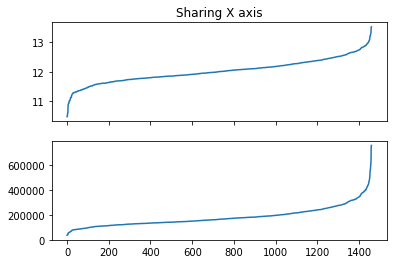

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

#transform the target feature
log = np.sort(np.log1p(data_with_dummies['SalePrice']))
target_sort = np.sort(data_with_dummies['SalePrice'])
#Visualization of both 
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(log)
axarr[0].set_title('Sharing X axis')
axarr[1].plot(np.sort(data_with_dummies['SalePrice']))

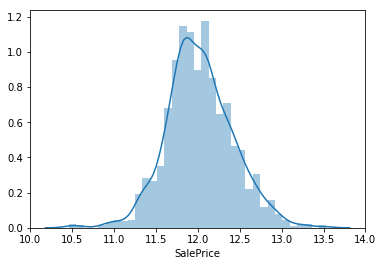

In [12]:
sns.distplot(np.log1p(data_with_dummies['SalePrice']))

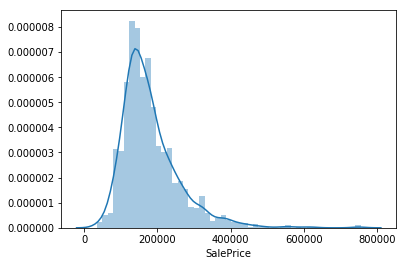

In [13]:
sns.distplot(data_with_dummies['SalePrice'])

We Can see that the shape of the distribution of the log transform is different to the distribution of the target features. We now have values between 10.5 and 13.5 wheras having values between 35k and 800k before. We also have a distribution looking like a normal distribution wheras before it looked like a Beta distribution.

The root mean square error between log of predicted price and log of observed price is a better metric than a RMSE applied directly on observed and predicted prices because the datas areare concentrated around the mean of the log. Therefore the distance will be more precise. With the Raw saleprice a long distance might cause a higher error.

In [14]:
#Cut the data between features and target
y = data_with_dummies['SalePrice']
X = data_with_dummies.drop(columns='SalePrice')

**Q 6:** Visualize the correlation of different features with target and sort them based on the absolute value of correlation. What are the top 10 correlated values ? Do all of them make sense compared to your prior expectation ?

Hint: To compute pearson correlation of two dataframe columns A and B, do the following:

*df['A'].corr(df['B'])*

In [15]:
# Visualize corelation of different features with respect to target

# Compute the correlation matrix
corr_dic = {}
above_10 = []
for column in data_with_dummies.columns:
    corr_dic[column] = abs(data_with_dummies[column]
                           .corr(data_with_dummies['SalePrice']))
    if abs(data_with_dummies[column].corr(data_with_dummies['SalePrice']))>0.1:
        above_10.append(column)

for w in sorted(corr_dic, key=corr_dic.get, reverse=True):
    print (w, corr_dic[w])

SalePrice 1.0
OverallQual 0.7909816005838044
GrLivArea 0.7086244776126523
ExterQual 0.6826392416562594
KitchenQual 0.6595997207286639
BsmtQual 0.6501380175698004
GarageCars 0.6404091972583529
GarageArea 0.6234314389183618
TotalBsmtSF 0.6135805515591956
1stFlrSF 0.6058521846919147
FullBath 0.5606637627484449
TotRmsAbvGrd 0.5337231555820282
YearBuilt 0.5228973328794969
YearRemodAdd 0.5071009671113865
Foundation_PConc 0.4977337525869366
MasVnrArea 0.47524131677366865
Fireplaces 0.46692883675152724
HeatingQC 0.427648707398804
Neighborhood_NridgHt 0.4021485981752672
BsmtFinSF1 0.3864198062421532
MSSubClass_60 0.37719706842810663
MasVnrType_None 0.36745636519324915
BsmtExposure 0.36186283187566526
SaleType_New 0.35750940508319323
SaleCondition_Partial 0.35205985467143436
Foundation_CBlock 0.3432629994446493
MasVnrType_Stone 0.330475646543412
Neighborhood_NoRidge 0.3304236257653571
WoodDeckSF 0.3244134445681294
2ndFlrSF 0.3193338028320681
OpenPorchSF 0.3158562271160555
Exterior2nd_VinylSd 0.3

In [16]:
i=0
print('The 10 most corrolated features are :')

for w in sorted(corr_dic, key=corr_dic.get, reverse=True):
    if i==11:
        break
    if i!=0:
        print(w, corr_dic[w])
    i+=1

The 10 most corrolated features are :
OverallQual 0.7909816005838044
GrLivArea 0.7086244776126523
ExterQual 0.6826392416562594
KitchenQual 0.6595997207286639
BsmtQual 0.6501380175698004
GarageCars 0.6404091972583529
GarageArea 0.6234314389183618
TotalBsmtSF 0.6135805515591956
1stFlrSF 0.6058521846919147
FullBath 0.5606637627484449


We decide to keep only the features with a correlation greater than 10% with the output

In [17]:
clean_data = data_with_dummies.drop(data_with_dummies.columns.drop(above_10),axis=1)
clean_data.head()

,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,...,Exterior1st_CemntBd,Exterior1st_MetalSd,Exterior1st_VinylSd,Exterior1st_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,LotConfig_CulDSac,HouseStyle_1.5Fin,HouseStyle_2Story
0,8450,7,2003,2003,196.0,3,4,3,1,6,...,0,0,1,0,1,0,0,0,0,1
1,9600,6,1976,1976,0.0,2,4,3,4,5,...,0,1,0,0,0,1,0,0,0,0
2,11250,7,2001,2002,162.0,3,4,3,2,6,...,0,0,1,0,1,0,0,0,0,1
3,9550,7,1915,1970,0.0,2,3,4,1,5,...,0,0,0,1,0,1,0,0,0,1
4,14260,8,2000,2000,350.0,3,4,3,3,6,...,0,0,1,0,1,0,0,0,0,1


## Part 2: Preparing Baseline and Cross-Validation Schema

**Q 1:** Divide your cleaned dataset into a test set and a training set with ratio of 1 to 4. Dont forget to shuffle your data before hand.

Hint: Divide data into training and test sets using *train_test_split()* function in *sklearn.model_selection* package.

In [18]:
from sklearn.model_selection import train_test_split
# Should we use y OR log1P(y) ???? PROBABLY USE THE LOG
# Split target and features into test and training sets
seed = 1
X_train, X_test, y_train, y_test = train_test_split(clean_data, y, test_size = 0.2, random_state = seed)

**Q 2:** Come up with a proper baseline to compare with your more advanced models. Consider root mean square error as your regression performance metric to give the error in the same unit as target. Print the baseline performance.

Hint: Fit an object from *DummyRegressor* class in *sklearn.dummy* package to training set and evaluate the performance on the test set. Keep the strategy of *DummyRegressor* object as default (mean).

In [19]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

#compute a proper baseline to compare the results
def RMSE_log(y_test,y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred)))

dummy_reg = DummyRegressor()
dummy_reg.fit(X_train,y_train)
y_pred = dummy_reg.predict(X_test)


err = RMSE_log(y_test,y_pred)
print(err)

0.4356030282531984


## Part 3: Ridge Regression

**Q 1:** Fit a ridge regression model to your data and tune the value of alpha parameter. Note that your data should be standardize. Use validation curve to visualize your tuning process.

Hint: Use the *Pipeline* class from *sklearn.pipeline* package to make a pipeline of *StandardScaler* and *Ridge* transformers. Use *validation_curve()* function from *sklearn.model_selection* package on the training set and tune the value of alpha. 

To visualize your tuning process, use the following function:


In [20]:
def plot_validation_curve(train_scores,cv_scores,x_data,scale='lin',title='',y_label='',x_label=''):

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        cv_scores_mean = np.mean(cv_scores, axis=1)
        cv_scores_std = np.std(cv_scores, axis=1)

        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        lw = 2

        plt.fill_between(x_data, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.2, color="r", lw=lw)
        plt.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="g", lw=lw)

        if (scale == 'lin'):
            plt.plot(x_data, train_scores_mean, 'o-', color="r", label="Training score")
            plt.plot(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
        elif (scale == 'log'):
            plt.semilogx(x_data, train_scores_mean, 'o-', color="r", label="Training score")
            plt.semilogx(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
        plt.grid()
        plt.legend(loc="best")
        plt.show()

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

seed_val=2
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, 
                                                                    test_size = 0.25, random_state = seed_val)

# Standardize features Ridge in a single pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('ridge_regression', Ridge()))

pipeline = Pipeline(estimators)
pipeline.set_params(ridge_regression__alpha='alpha')

# Finding best value of ALPHA using validation set
scores = []
alphas = []
for alpha in np.logspace(-10, 4, 50):
    pipeline.set_params(ridge_regression__alpha=alpha) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict(X_train_val)
    scores.append(RMSE_log(y_train_val, y_train_pred))
    #scores.append(pipeline.score(X_train_val,y_train_val))
    alphas.append(alpha)

#best_score = find_nearest(scores,0)
best_alpha = alphas[scores.index(min(scores))]
print ('best alpha = %2.10f with RMSE_log = %2.15f' %(best_alpha, min(scores)))

best alpha = 0.0000000004 with RMSE_log = 0.000000000000607


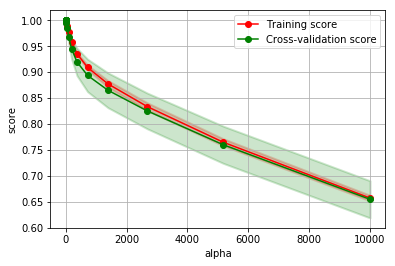

In [22]:
from sklearn.model_selection import validation_curve

train_scores, valid_scores= validation_curve(pipeline,X_train,y_train,
                                             "ridge_regression__alpha",np.logspace(-10, 4, 50),cv=5)

plot_validation_curve(train_scores,valid_scores,np.logspace(-10, 4, 50),x_label='alpha',y_label='score')

**Q 2:** Report its performance on test data. Is this estimation fully reliable? why?

Hint: Set the value of alpha to the optimum value. Fit your pipeline to training data and predict the house prices on test data. Use *mean_squared_error()* function from *sklearn.metrics* package to measure your regression performance.

In [23]:
# Performance of the tuned model on test set
pipeline.set_params(ridge_regression__alpha=best_alpha)
pipeline.fit(X_train,y_train)
y_pred_ridge = pipeline.predict(X_test)
rmse_score_ridge = RMSE_log(y_test,y_pred_ridge)
print(rmse_score_ridge)
#print(y_pred_ridge)
#pipeline.score(X_test,y_test)

4.710558062939095e-13


It seems reliable because both curve the training curve and the cross validation score are very close.

**Q 3:** Print the list of ridge coefficients. 

Hint: Extract the ridge regression from your pipeline and use its methods directly.

In [24]:
ridge = pipeline.named_steps['ridge_regression']
print(ridge.coef_)

[ 1.18336403e-08  2.84213746e-08 -1.44222018e-08  4.31935551e-09
  8.25250450e-09  1.10758174e-08  1.17661883e-08  4.52150486e-09
  1.54518045e-08  5.85828357e-09  2.58120782e-10 -9.09534087e-09
  8.22938724e-09  6.33410535e-09  3.84012612e-08  4.67739387e-08
  5.00733141e-10  4.16390094e-09  7.87451242e-09  4.95859611e-09
 -6.54364881e-09 -5.91394518e-09  1.33717913e-08  2.12916101e-08
  9.03550147e-09  8.72859528e-09  1.68620045e-08 -2.13301575e-10
  4.14014138e-09  3.15295285e-09  1.76474061e-09  7.78624251e-09
  7.80526500e+04  6.06253189e-08  2.59574416e-08  6.36865748e-08
  1.82407858e-08 -2.15973419e-09  8.45500493e-10  1.00648782e-08
  1.14000455e-08  1.29923981e-08 -8.51796706e-09  7.64278788e-09
  2.70126530e-09  2.21720708e-09 -1.09798038e-08 -9.25662333e-10
 -2.99012514e-09 -6.62471803e-09  1.63523241e-08  2.75914062e-08
 -8.49738463e-09 -2.93555459e-09  7.98123281e-09  1.77677729e-08
  1.01047073e-09  2.49832266e+01  2.49832266e+01  1.53910232e-08
  2.25788946e-08  3.10412

## Part 4: Lasso Regression

**Q 1:** Fit a Lasso regression model to your data and tune the value of alpha parameter. Note that your data should be standardize. Use validation curve to visualize your tuning process.

In [48]:
from sklearn.linear_model import Lasso

# Standardize features Ridge in a single pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('Lasso', Lasso()))

pipeline_lasso = Pipeline(estimators)
pipeline_lasso.set_params(Lasso__alpha='alpha')

# Finding best value of ALPHA using validation set
scores = []
alphas = []
for alpha in np.logspace(-10, 4, 50):
    pipeline_lasso.set_params(Lasso__alpha=alpha) 
    pipeline_lasso.fit(X_train_train,y_train_train)
    y_train_pred = pipeline_lasso.predict(X_train_val)
    scores.append(RMSE_log(y_train_val, y_train_pred))
    #scores.append(pipeline.score(X_train_val,y_train_val))
    alphas.append(alpha)

#best_score = find_nearest(scores,0)
best_alpha = alphas[scores.index(min(scores))]
print ('best alpha = %2.10f with RMSE_log = %2.15f' %(best_alpha, min(scores)))

best alpha = 3.7275937203 with RMSE_log = 0.000030920531922


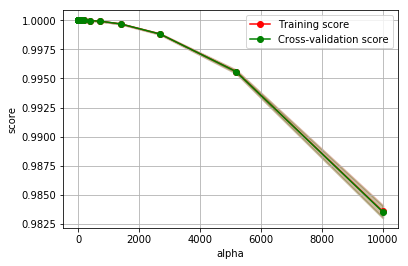

In [49]:
train_scores_lasso, valid_scores_lasso= validation_curve(pipeline_lasso,X_train,y_train,
                                             "Lasso__alpha",np.logspace(-10, 4, 50),cv=5)

plot_validation_curve(train_scores_lasso,valid_scores_lasso,
                      np.logspace(-10, 4, 50),x_label='alpha',y_label='score')

**Q 2:** Report its performance on test data.

In [50]:
# Performance of the tuned model on test set
pipeline_lasso.set_params(Lasso__alpha=best_alpha)
pipeline_lasso.fit(X_train,y_train)
y_pred_Lasso = pipeline_lasso.predict(X_test)
rmse_score_lasso = RMSE_log(y_test,y_pred_Lasso)
print(rmse_score_lasso)
#print(pipeline_lasso.score(X_test,y_test))

3.5626930873284245e-05


**Q 3:** Print the list of ridge coefficients. How do they differ from ridge coefficients ? What would be the benefit ?

In [51]:
lasso = pipeline_lasso.named_steps['Lasso']
print(lasso.coef_)

[    0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.            -0.             0.             0.
     0.             0.             0.             0.
     0.             0.            -0.             0.
 78047.82231383     0.             0.            -0.
     0.            -0.             0.            -0.
     0.            -0.            -0.             0.
    -0.            -0.            -0.            -0.
    -0.            -0.             0.             0.
    -0.            -0.             0.             0.
     0.            -0.             0.            -0.
     0.            -0.             0.            -0.
     0.             0.            -0.            -0.
     0.            -0.            -0.            -0.
     0.            -0.            -0.         

We can drop lots of features since their parameters equal 0..

## Part 5: Random Forest

**Q 1:** Fit a random forest model to your data and tune the value of n_estimators parameter. Use validation curve to visualize your tuning process. Note that tree based models does not require standardized features to function correctly.

In [29]:
from sklearn.ensemble import RandomForestRegressor

seed_val=2
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, 
                                                                    test_size = 0.25, random_state = seed_val)

# Standardize features Ridge in a single pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('RandomForest_reg', RandomForestRegressor()))

pipeline_rdmForest = Pipeline(estimators)
pipeline_rdmForest.set_params(RandomForest_reg__n_estimators='n_estimators')

# Finding best value of ALPHA using validation set
scores = []
n_estimators = []
for n_estimator in range(1, 150):
    pipeline_rdmForest.set_params(RandomForest_reg__n_estimators=n_estimator) 
    pipeline_rdmForest.fit(X_train_train,y_train_train)
    y_train_pred = pipeline_rdmForest.predict(X_train_val)
    scores.append(RMSE_log(y_train_val, y_train_pred))
    #scores.append(pipeline.score(X_train_val,y_train_val))
    n_estimators.append(n_estimator)

#best_score = find_nearest(scores,0)
best_n_estimators = n_estimators[scores.index(min(scores))]
print ('best alpha = %2.10f with RMSE_log = %2.15f' %(best_n_estimators, min(scores)))

best alpha = 5.0000000000 with RMSE_log = 0.026658809894292


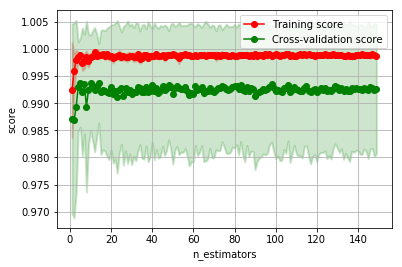

In [32]:
train_scores_rdmForest, valid_scores_rdmForest= validation_curve(pipeline_rdmForest,X_train,y_train,
                                             "RandomForest_reg__n_estimators",list(range(1,150)),cv=5)

plot_validation_curve(train_scores_rdmForest,valid_scores_rdmForest,
                      list(range(1,150)),x_label='n_estimators',y_label='score')

**Q 2:** Report its performance on test data.

In [31]:
# Performance of the tuned model on test set
pipeline_rdmForest.set_params(RandomForest_reg__n_estimators=best_n_estimators)
pipeline_rdmForest.fit(X_train,y_train)
y_pred_rdmForest = pipeline_rdmForest.predict(X_test)
rmse_score_rdmForest = RMSE_log(y_test,y_pred_Lasso)
print(rmse_score_rdmForest)

2.9308026362331085e-05


**Q 3:** Print list of 10 most important features in order. 

## CHECK AGAIN

In [33]:
def importance_features(pipe,n_importance):
    arr = np.array(pipe.named_steps['RandomForest_reg'].feature_importances_)
    idx = (-arr).argsort()[:n_importance]
    print("Importance of features "+str(arr))
    print("The "+str(n_importance)+" most important features are ")
    return X_test.columns[idx]

In [34]:
importance_features(pipeline_rdmForest,10)

Importance of features [3.11192139e-04 1.45609215e-04 1.23451964e-03 1.33416963e-03
 3.71935727e-05 5.30108530e-08 1.95579258e-06 1.25082046e-08
 8.45070208e-06 9.53572501e-06 4.68107502e-05 2.98539268e-06
 8.45970062e-06 4.37945945e-07 2.39168213e-05 6.24562937e-07
 6.35042215e-05 4.88663918e-06 1.28015914e-07 6.25313485e-07
 5.20805950e-07 2.49125937e-08 2.89203342e-07 6.04929813e-06
 3.31104050e-08 3.55318786e-06 6.91013185e-07 1.61185084e-04
 5.80049496e-06 4.94963042e-06 9.27544997e-08 5.29180071e-08
 9.94879676e-01 5.08735318e-09 1.92428927e-07 2.29385421e-08
 7.65444542e-07 5.26568860e-07 2.61120824e-07 1.46506630e-08
 4.48720802e-08 1.31144362e-07 1.97319539e-07 2.23836669e-08
 1.02115880e-07 1.11557113e-07 1.55485842e-06 1.61880502e-08
 2.49292095e-07 3.10086449e-08 1.52821178e-07 1.31742428e-07
 5.88025680e-04 1.30031946e-05 3.98882506e-08 1.85754524e-06
 8.02660176e-08 2.47102029e-10 5.69414948e-09 1.58407212e-08
 3.11706491e-08 2.02366774e-07 3.35733742e-07 9.18897972e-08
 

Index(['SalePrice', 'YearRemodAdd', 'YearBuilt', 'SaleType_New',
       'RoofStyle_Gable', 'LotArea', 'GarageArea', 'OverallQual', 'GrLivArea',
       'BsmtFinSF1'],
      dtype='object')

## Part 6: Gradient Boosted Trees

**Q 1:** Fit a gradint boosted tree model to your data and tune the value of n_estimators parameter. Use validation curve to visualize your tuning process.

In [36]:
from sklearn.ensemble import GradientBoostingRegressor


seed_val=2
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, 
                                                                    test_size = 0.25, random_state = seed_val)

# Standardize features Ridge in a single pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('GradientBoosted_reg', GradientBoostingRegressor()))

pipeline_gdtBoosted = Pipeline(estimators)
pipeline_gdtBoosted.set_params(GradientBoosted_reg__n_estimators='n_estimators')

# Finding best value of ALPHA using validation set
scores = []
n_estimators = []
for n_estimator in range(1, 200):
    pipeline_gdtBoosted.set_params(GradientBoosted_reg__n_estimators=n_estimator) 
    pipeline_gdtBoosted.fit(X_train_train,y_train_train)
    y_train_pred = pipeline_gdtBoosted.predict(X_train_val)
    scores.append(RMSE_log(y_train_val, y_train_pred))
    #scores.append(pipeline.score(X_train_val,y_train_val))
    n_estimators.append(n_estimator)

#best_score = find_nearest(scores,0)
best_n_estimators_gdt = n_estimators[scores.index(min(scores))]
print ('best alpha = %2.10f with RMSE_log = %2.15f' %(best_n_estimators_gdt, min(scores)))

best alpha = 197.0000000000 with RMSE_log = 0.016501474307240


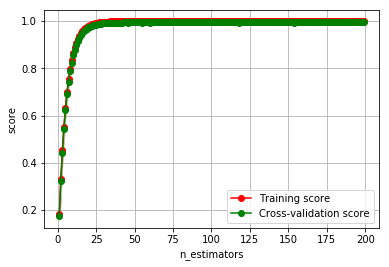

In [37]:
train_scores_rdmForest, valid_scores_rdmForest= validation_curve(pipeline_gdtBoosted,X_train,y_train,
                                             "GradientBoosted_reg__n_estimators",list(range(1,200)),cv=5)

plot_validation_curve(train_scores_rdmForest,valid_scores_rdmForest,
                      list(range(1,200)),x_label='n_estimators',y_label='score')

**Q 2:** Report its performance on test data.

In [38]:
# Performance of the tuned model on test set
pipeline_gdtBoosted.set_params(GradientBoosted_reg__n_estimators=best_n_estimators_gdt)
pipeline_gdtBoosted.fit(X_train,y_train)
y_pred_gdtBoosted = pipeline_gdtBoosted.predict(X_test)
rmse_score_gdtBoosted = RMSE_log(y_test,y_pred_gdtBoosted)
print(rmse_score_gdtBoosted)

0.006154169328243444


**Q 3:** Print list of 10 most important features and compare it with what you get from random forest predictive model.

In [40]:
def importance_features(pipe,n_importance):
    arr = np.array(pipe.named_steps['GradientBoosted_reg'].feature_importances_)
    idx = (-arr).argsort()[:n_importance]
    print("Importance of features "+str(arr))
    print("The "+str(n_importance)+" most important features are ")
    return X_test.columns[idx]

In [41]:
importance_features(pipeline_gdtBoosted,10)

Importance of features [6.26558134e-02 3.44193846e-03 1.85989392e-02 1.71999645e-02
 3.00873796e-02 5.40775862e-03 0.00000000e+00 4.38227320e-03
 1.00726116e-02 3.46146639e-03 5.99555141e-02 3.20123845e-02
 1.75095368e-02 5.17616453e-03 3.60078175e-02 2.05106159e-02
 4.71424790e-02 6.62453851e-04 4.83584297e-03 1.91580425e-03
 9.45050288e-04 0.00000000e+00 7.54399469e-03 7.04356625e-03
 0.00000000e+00 1.06309164e-02 3.14207459e-03 2.90492011e-02
 3.17836312e-02 4.09592351e-02 1.08072850e-02 7.58765924e-03
 3.95779195e-01 0.00000000e+00 0.00000000e+00 1.36967654e-03
 0.00000000e+00 5.60079022e-04 0.00000000e+00 0.00000000e+00
 4.39185803e-03 2.09899991e-03 0.00000000e+00 0.00000000e+00
 7.10656541e-03 1.59624798e-03 1.15463135e-03 5.08847716e-04
 1.68154887e-03 0.00000000e+00 7.17704058e-04 5.53171734e-03
 2.65428589e-03 2.14990116e-03 2.06595205e-03 5.36686519e-04
 1.54376906e-03 0.00000000e+00 0.00000000e+00 1.59885677e-03
 0.00000000e+00 4.21262731e-03 1.81685594e-03 1.22011789e-03
 

Index(['SalePrice', 'LotArea', 'BsmtFinSF1', 'GrLivArea', 'OpenPorchSF',
       '1stFlrSF', 'BsmtUnfSF', 'WoodDeckSF', 'MasVnrArea', 'GarageArea'],
      dtype='object')

## Part 7: Prediction Improvement: More Data

**Q 1:** Try to answer whether investing on more data could make sense by choosing the best predictive model you obtained above and apply a training curve on it.

Hint: Use *learning_curve()* function from *sklearn.model_selection* to assess performance of your model using training data with different sizes. Consider 0.1, 0.2, ..., 1.0 times of the training size. Use the following function to visualize your learning curve:


##### The best model obtained above is the Ridge regression

In [25]:
def plot_learning_curve(train_scores,cv_scores,x_data,scale='lin',title='',y_label='',x_label=''):

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        cv_scores_mean = np.mean(cv_scores, axis=1)
        cv_scores_std = np.std(cv_scores, axis=1)

        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        lw = 2

        plt.fill_between(x_data, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.2, color="r", lw=lw)
        plt.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="g", lw=lw)

        if (scale == 'lin'):
            plt.plot(x_data, train_scores_mean, 'o-', color="r", label="Training score")
            plt.plot(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
        elif (scale == 'log'):
            plt.semilogx(x_data, train_scores_mean, 'o-', color="r", label="Training score")
            plt.semilogx(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
        plt.grid()
        plt.legend(loc="best")
        plt.show()
        
from sklearn.model_selection import learning_curve

In [47]:
train_scores_r, valid_scores_r = learning_curve(pipeline,X_train,y_train,
                                                n_jobs)
plot_learning_curve(train_scores_r,valid_scores_r)

ValueError: too many values to unpack (expected 2)

**Q 2:** What strategies regarding data can be proposed to come up with a better prediction ?

We could either lower the threshold of correlation for the dropping data (or Add more Observations to our training data) to get a better model with better parameters, thus a better Model with more precise predictions.

## Part 8: Prediction Improvement: Better Model

**Q 1:** Create a simple ensemble regressor using the average of your two best models. Compare its performance with each of the two individual models.

In [ ]:
y_pred_ensemble = np.mean([y_pred_ridge,y_pred_Lasso])

rmse_score_ensemble = RMSE_log(y_test,y_pred_ensemble)

print(rmse_score_ensemble)
print(y_pred_ridge)
print(y_pred_Lasso)

**Q 2:** How can you make your performance results statistically more reliable ?

Hint: Consider sources of selection bias.

**Q 3:** What strategies regarding modeling technique can be proposed to come up with a better prediction ?

## Bonus: Food for Thought

To read: https://www.aeaweb.org/articles?id=10.1257/jep.31.2.87

To watch: https://www.ted.com/talks/anne_milgram_why_smart_statistics_are_the_key_to_fighting_crime